In [1]:
import sys
import importlib
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

import torch

importlib.reload(c)
importlib.reload(u)
importlib.reload(mu)

<module 'utilities.model_utils' from 'd:\\!!!_PDF\\Fizyka i matma studia\\!!!_Leiden\\!! projekty 2024_25\\Evert van Niewenburg\\potencial projects\\Qdarts projects\\qdarts_code\\learning_parameters\\utilities\\model_utils.py'>

### Looking at the data

c_dd = [[54.1562, 3.9572, 0.7339], [3.9572, 16.2403, 0.9255], [0.7339, 0.9255, 10.814499999999999]]
c_dg = [[23.9894, 1.1306, 0.029], [1.1306, 4.8495, 0.1204], [0.029, 0.1204, 4.0341]]


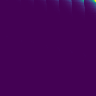

In [10]:
%matplotlib inline
if c.PATH_0 == './ALICE/':
    batch_number = 2
    img_number = '0035487789'
else:
    batch_number = 3
    img_number = '0060485230'

# u.reconstruct_img_with_matrices(batch_number, img_number, True)[0]
fig, c_dd, c_dg = u.reconstruct_img_with_matrices(6, '1495064182', [3,2,1])
print(f"c_dd = {c_dd.tolist()}\nc_dg = {c_dg.tolist()}")
fig

### Data preprocessing

In [ ]:
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

#### Reconstructed image from saved np.ndarray

In [8]:
example = datapoints[19] # 67, 19

In [ ]:
example_csd = example[0]
u.reconstruct_img_from_tensor(example_csd)

#### The preprocessed input seen by the model

In [ ]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

#### Output preproccess

In [ ]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

In [ ]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

#### Filter dataset

In [ ]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

#### Train model

### Unit tests

In [15]:
c_dd, c_dg = u.generate_capacitance_matrices()
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
c_dd_rec, c_dg_rec = mu.reconstruct_capacitance_matrices(output)

assert (c_dd == c_dd_rec).all() and (c_dg == c_dg_rec).all()

In [16]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)outputmupepocess_cpacitance_matricesc_ddc_dg
# c_m = 0.5
# c_dd = np.array([[3.1, 0.5], [0.5, 2.9]])
# np.sum(c_dg, axis=1).T*np.eye(c.K)+c_m

c_dd, c_dg = u.generate_capacitance_matrices()
c_m =  c_dd[0,1]

c_dd_test = np.array([[c_dg[0,0]+c_dg[0,1]+c_m, c_m], [c_m, c_dg[1,0]+c_dg[1,1]+c_m]])

if c.K == 2:
    assert (c_dd == c_dd_test).all()
    assert c_dd[0,1] == c_dd[1,0]

### XAI

In [ ]:
test = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(41,42))
u.reconstruct_img_from_tensor(test[0][0])

In [ ]:
example_X, example_Y = mu.prepare_data(datasize_cut=1, 
                                       param_names=['csd', 'C_DD', 'C_DG'], 
                                       all_batches=False, batches=np.arange(41,42))

print(example_X.shape, example_Y.shape)
print(example_Y[-1])


In [ ]:
saliency_overlay, gradcam_overlay, prediction, reconstructed_matrices= mu.explain_output(
    input_tensor=example_X,
    model_name='resnet',
    model_path='./Results/resnet18/resnet18_model_20241028_104258/resnet18_model.pth')

print(prediction)
print(reconstructed_matrices)

In [ ]:
np.abs(np.array(example_Y) -  prediction)

In [ ]:
saliency_overlay

In [ ]:
gradcam_overlay

In [ ]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(prediction)
plot.show()

### Noise - test

In [2]:
c.NOISE = True

x_vol = np.linspace(0, 0.05, c.RESOLUTION)
y_vol = np.linspace(0, 0.05, c.RESOLUTION)
ks = 0
device = np.array([[1,1]])

S=1
N=len(u.get_dots_indices(device))
K=N+S
config_tuple = (K,N,S)

C_DD, C_DG, ks, cut, x, y, csd, poly, sensor, device = u.generate_dataset(x_vol, y_vol, ks, device, config_tuple)

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[15.3443  3.2763  1.1574]
 [ 3.2763 16.0953  1.9165]
 [ 1.1574  1.9165 15.6868]]
                Dot-gate capacitances: 
                [[4.93   1.2601 0.0415]
 [1.2601 4.0343 0.1782]
 [0.0415 0.1782 6.6333]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [-1]
            Sensor detunings: [-20.] meV
            Coulomb peak width: 0.68 meV
            Slow noise amplitude: 50.0 ueV
            Fast noise amplitude: 50.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 1.e-06 0.e+00]
 [1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]]
            Temperature: 0.1 K
            Energy range factor: 5
   

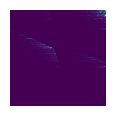

In [6]:
%matplotlib inline
fig, ax = u.plot_CSD(x, y, sensor, poly)  

In [7]:
assert np.all(np.sum([np.gradient(sensor, axis=i) for i in [0,1]], axis=0) == np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))

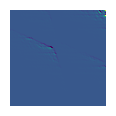

In [8]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Device

In [37]:
# device = np.array([[0,1, 0,1,0],[1,0,1,0,1],[0,1,0,1,0]])
# device = np.ones((2,2))
# device = np.ones((1,3))
device = np.array([[1,1,0,0,1]])

# r0 = [c.d_DD*np.sqrt(0.5**2+3**2)]
# t0 = [np.arctan(3/0.5)]
r0 = [6*c.d_DD]
t0 = [0]
S = len(t0)
N = len(u.get_dots_indices(device))
K = N+S

sensors = u.set_sensors_positions(S, device, list_r0=r0, list_theta0=t0)
# sensors = u.set_sensors_positions(S, device)

print(device, sensors)

[[1 1 0 0 1]] [(600, 0)]


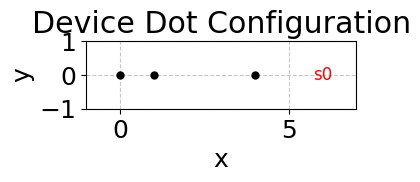

In [38]:
# Example usage:
%matplotlib inline
fig, ax = u.plot_device_lattice(device, sensors)
plt.show()